In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statannot import add_stat_annotation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import quick_load_liuzhong_health_check_data, parse_dict_with_default
from plot_utils import Stack, Scatter, Sankey, BxxPvalue

warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_group, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/figures"

# xgboost Training

## feature engineering

In [2]:
df_t_change = pd.melt(
    df_table1plus_3p_revMM[ ["sample_id", 'HEART.T_change', "period", "month", "age_groups","gender"] ],
    id_vars = ["sample_id", "month", "period", "age_groups", "gender"]
).pivot(index=["sample_id","variable", "month", "age_groups", "gender"], 
        columns="period", values="value").reset_index()

l_t_change_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Control-2022"]==0) & (df_t_change["Test-2023"]==1)
]["sample_id"]

l_t_norm_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==0)
]["sample_id"]

l_t_change_22_23 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Control-2022"]==1) & (df_t_change["Test-2023"]==1)
]["sample_id"]

sub_ = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_norm_2023)]
sub_["group"] = "t-norm_2023"
sub_23 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_2023)]
sub_23["group"] = "t-abnorm_2023"
sub_2223 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_22_23)]
sub_2223["group"] = "t-abnorm_22-23"

df_t_group = pd.concat([sub_, sub_23, sub_2223])
# df_t_group = pd.concat([sub_, sub_23])
df_t_group["group_each_year"] = df_t_group.apply(lambda x: f"{x['group']}-{x['period']}" , axis=1)
df_t_group["group_num"] = [ 0 if x=="t-norm_2023" else 1 for x in df_t_group["group"] ]
df_t_group

variable,gender,sample_id,period,month,birthday,GALLBLADDER.GallBladderPolyps,HEART.AtrialFibrillation,HEART.ElectricAxisDeviation,HEART.ExtraSystole,HEART.HeartBlocks,...,v9925,vJ1000,year,age,year-month,age_groups,period_age,group,group_each_year,group_num
0,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,Control-2021,2,1993-05-22,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,2021,28,2021-02,<30,Control-2021_<30,t-norm_2023,t-norm_2023-Control-2021,0
1,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,Control-2022,2,1993-05-22,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,29,2022-02,<30,Control-2022_<30,t-norm_2023,t-norm_2023-Control-2022,0
2,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,Test-2023,2,1993-05-22,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2023,30,2023-02,30-45,Test-2023_30-45,t-norm_2023,t-norm_2023-Test-2023,0
12,female,+/xHqjtQDEh997ACmNNfmMytDzl7YNZxVFe5NtZKVQZyuw==,Control-2021,2,1982-07-27,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2021,39,2021-02,30-45,Control-2021_30-45,t-norm_2023,t-norm_2023-Control-2021,0
13,female,+/xHqjtQDEh997ACmNNfmMytDzl7YNZxVFe5NtZKVQZyuw==,Control-2022,2,1982-07-27,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,40,2022-02,30-45,Control-2022_30-45,t-norm_2023,t-norm_2023-Control-2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61957,male,vwcGSchg5jsG7SxV3BR7UMytDz5zYtZxWVK4MdZNUg531g==,Control-2022,1,1957-10-20,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,2022,65,2022-01,>60,Control-2022_>60,t-abnorm_22-23,t-abnorm_22-23-Control-2022,1
61958,male,vwcGSchg5jsG7SxV3BR7UMytDz5zYtZxWVK4MdZNUg531g==,Test-2023,1,1957-10-20,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2023,66,2023-01,>60,Test-2023_>60,t-abnorm_22-23,t-abnorm_22-23-Test-2023,1
62157,male,wQmfAKTokYG2TISjjYiWIcytDz5zZdZxWlG5N9dNUQtxuA==,Control-2021,2,1964-06-30,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2021,57,2021-02,45-60,Control-2021_45-60,t-abnorm_22-23,t-abnorm_22-23-Control-2021,1
62158,male,wQmfAKTokYG2TISjjYiWIcytDz5zZdZxWlG5N9dNUQtxuA==,Control-2022,2,1964-06-30,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,58,2022-02,45-60,Control-2022_45-60,t-abnorm_22-23,t-abnorm_22-23-Control-2022,1


## generate xgb input file

In [3]:
l_core = list(df_meta_group["item_id"])
df_23 = pd.DataFrame(df_t_group[df_t_group["period"]=="Test-2023"][l_core].values)
df_22 = pd.DataFrame(df_t_group[df_t_group["period"]=="Control-2022"][l_core].values)
df_21 = pd.DataFrame(df_t_group[df_t_group["period"]=="Control-2021"][l_core].values)

eps = 1e-3
col_name = [ parse_dict_with_default(x, rename_dict) for x in l_core ]
df_23_22_d = pd.DataFrame(df_23.values - df_22.values, columns=[f"{x}_23_22_d" for x in col_name])
df_22_21_d = pd.DataFrame(df_22.values - df_21.values, columns=[f"{x}_22_21_d" for x in col_name])
df_23_22_r = pd.DataFrame((df_23.values+eps) / (df_22.values+eps), columns=[f"{x}_23_22_r" for x in col_name])
df_22_21_r = pd.DataFrame((df_22.values+eps) / (df_21.values+eps), columns=[f"{x}_22_21_r" for x in col_name])

df_23.columns = [f"{x}_23" for x in col_name]
df_22.columns = [f"{x}_22" for x in col_name]
df_21.columns = [f"{x}_21" for x in col_name]


df_X = pd.concat([df_23, df_22, df_21, df_23_22_d, df_22_21_d, df_23_22_r, df_22_21_r], axis=1).\
        drop(list(filter(lambda x: x[0:5]=="HEART", df_23.columns)) + \
             list(filter(lambda x: x[0:5]=="HEART", df_23_22_d.columns)) + \
             list(filter(lambda x: x[0:5]=="HEART", df_23_22_r.columns)), axis=1)

df_X["age"] = [x for x in df_t_group[df_t_group["period"]=="Test-2023"]["age"] ]
df_X["gender"] = [ parse_dict_with_default(x, {"female":0, "male":1}) for x in df_t_group[df_t_group["period"]=="Test-2023"]["gender"] ]

df_Y = df_t_group[df_t_group["period"]=="Test-2023"]["group_num"]

df_X_csv = df_X.copy()
df_X_csv["Y"] = df_Y.values
df_X_csv.to_csv(f"{workdir}/Table_xgboost.csv")


## Training xgb

Train Accuracy: 89.38%


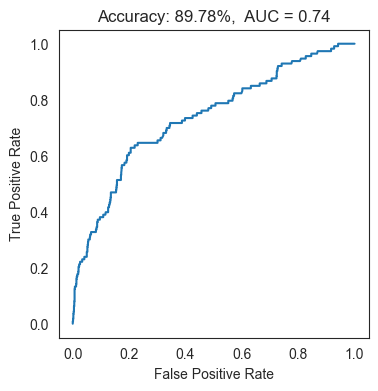

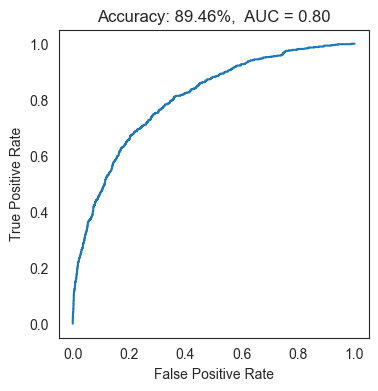

In [4]:

# 预测测试集
model = xgb.XGBClassifier(max_depth=2, min_child_weight=40, gamma=10)

from sklearn.metrics import roc_curve

# 将特征和标签分开
X = df_X.values
y = df_Y.values

# 打乱数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
# model.save_model("../../analysis/liuzhong/human/clinical/xgb_23Jan-Feb_t-wave.xgb")
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))


# 计算准确性
def plot_roc(X_test, y_test, figsize=(4,4)):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]

    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.plot(fpr,tpr)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.set_title("Accuracy: %.2f%%,  AUC = %.2f" % (accuracy*100, auc))
    return fig

fig = plot_roc(X_test, y_test)
fig.savefig(f"{workdir}/Figure3_A.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure3_xgb-ROC-curve-test.pdf")
fig = plot_roc(X, y)
# fig.savefig(f"{workdir}/Figure2_B.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure3_xgb-ROC-curve-all.pdf")

# interpreting xgboost trees

## get importance

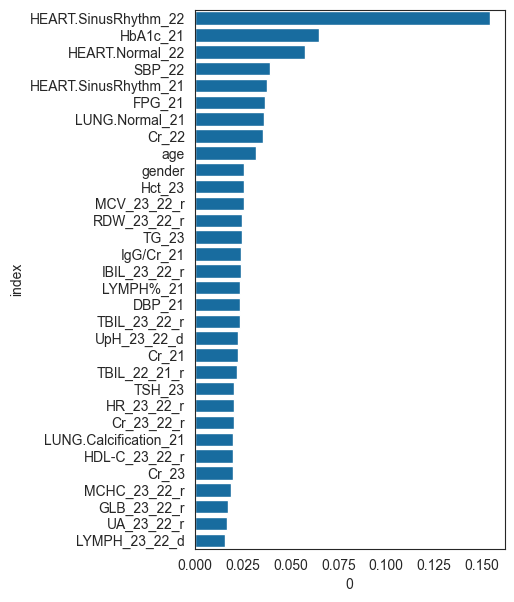

In [5]:
feature_importance = pd.Series(model.feature_importances_, index=df_X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
df_importance = feature_importance[feature_importance>0].reset_index()


fig = plt.figure(figsize=(4,7))
ax = fig.add_subplot(1,1,1)
sns.barplot(data=df_importance, x=0, y="index", ax=ax, color="#0172B6")
fig.savefig(f"{workdir}/Figure3_B.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure3_why_Tchange-xgb_importance.pdf")

## Plot xgb-trees

In [6]:
# for i in range(30):
#     xgb.plot_tree(model, num_trees=i)
#     plt.title(f"TREE{i}")
#     plt.show()

In [7]:
l_nodes = [
    [118,815,115], [118,815,250], [117,257], [118,815,172], [117,815],
    [117,250], [237,816,13], [117,172], [815,632,291], [30,255],
    [117,326,583], [634,614], [237,636], [427,235,291], [30,260,],
    [245,53], [653,115], [645,326], [389,751,617], [632,106],
    [653,616], [117,598],
]
for i_tree,nodes in enumerate(l_nodes):
    s_out = ",".join([f"{df_X.columns[x]}" for x in nodes])
    print(f"TREE{i_tree}, {s_out}")

TREE0, HEART.SinusRhythm_22,age,SBP_22
TREE1, HEART.SinusRhythm_22,age,LUNG.Normal_21
TREE2, HEART.Normal_22,HbA1c_21
TREE3, HEART.SinusRhythm_22,age,Cr_22
TREE4, HEART.Normal_22,age
TREE5, HEART.Normal_22,LUNG.Normal_21
TREE6, HEART.SinusRhythm_21,gender,TG_23
TREE7, HEART.Normal_22,Cr_22
TREE8, age,TBIL_23_22_r,Cr_21
TREE9, Hct_23,FPG_21
TREE10, HEART.Normal_22,IgG/Cr_21,HR_23_22_r
TREE11, IBIL_23_22_r,MCV_23_22_r
TREE12, HEART.SinusRhythm_21,Cr_23_22_r
TREE13, UpH_23_22_d,DBP_21,Cr_21
TREE14, Hct_23,LYMPH%_21
TREE15, LUNG.Calcification_21,Cr_23
TREE16, GLB_23_22_r,SBP_22
TREE17, UA_23_22_r,IgG/Cr_21
TREE18, LYMPH_23_22_d,TBIL_22_21_r,RDW_23_22_r
TREE19, TBIL_23_22_r,TSH_23
TREE20, GLB_23_22_r,MCHC_23_22_r
TREE21, HEART.Normal_22,HDL-C_23_22_r


Text(0.5, 1.0, 'TREE9, Hct_23,FPG_21')

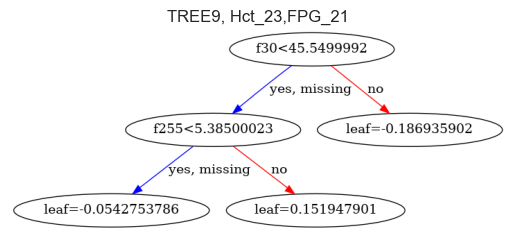

In [8]:
i = 9
xgb.plot_tree(model, num_trees=i)
s_out = ",".join([f"{df_X.columns[x]}" for x in l_nodes[i]])
plt.title(f"TREE{i}, {s_out}")


Text(0.5, 1.0, 'TREE18, LYMPH_23_22_d,TBIL_22_21_r,RDW_23_22_r')

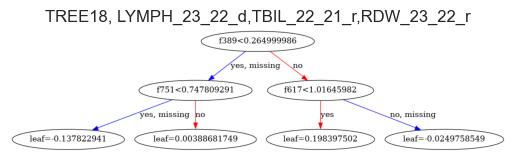

In [9]:
i = 18
xgb.plot_tree(model, num_trees=i)
s_out = ",".join([f"{df_X.columns[x]}" for x in l_nodes[i]])
plt.title(f"TREE{i}, {s_out}")


Text(0.5, 1.0, 'TREE19, TBIL_23_22_r,TSH_23')

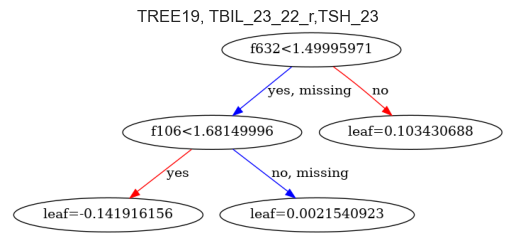

In [10]:
i = 19
xgb.plot_tree(model, num_trees=i)
s_out = ",".join([f"{df_X.columns[x]}" for x in l_nodes[i]])
plt.title(f"TREE{i}, {s_out}")


## df_t_change from discovery above

```python
plt_sankey.plot_sankey_subplots(df_cnt, [1,2], tag, l_age_groups, l_pairs)
```

In [11]:
df_t_change = pd.melt(
    df_table1plus_3p_revMM[ ["sample_id", 'HEART.T_change', "period", "month", "age_groups","gender"] ],
    id_vars = ["sample_id", "month", "period", "age_groups", "gender"]
).pivot(index=["sample_id","variable", "month", "age_groups", "gender"], 
        columns="period", values="value").reset_index()

l_t_change_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==1)
]["sample_id"]

l_t_norm_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==0)
]["sample_id"]

sub_ = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_norm_2023)]
sub_["group"] = "t-norm_2023"
sub_23 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_2023)]
sub_23["group"] = "t-abnorm_2023"

df_t_group = pd.concat([sub_, sub_23])
# df_t_group = pd.concat([sub_, sub_23])
df_t_group["group_each_year"] = df_t_group.apply(lambda x: f"{x['group']}-{x['period']}" , axis=1)
df_t_group["group_num"] = [ 0 if x=="t-norm_2023" else 1 for x in df_t_group["group"] ]
df_t_group

variable,gender,sample_id,period,month,birthday,GALLBLADDER.GallBladderPolyps,HEART.AtrialFibrillation,HEART.ElectricAxisDeviation,HEART.ExtraSystole,HEART.HeartBlocks,...,v9925,vJ1000,year,age,year-month,age_groups,period_age,group,group_each_year,group_num
0,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,Control-2021,2,1993-05-22,0.0,0.0,0.0,0.0,0.0,...,1.0,NaN,2021,28,2021-02,<30,Control-2021_<30,t-norm_2023,t-norm_2023-Control-2021,0
1,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,Control-2022,2,1993-05-22,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,29,2022-02,<30,Control-2022_<30,t-norm_2023,t-norm_2023-Control-2022,0
2,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,Test-2023,2,1993-05-22,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2023,30,2023-02,30-45,Test-2023_30-45,t-norm_2023,t-norm_2023-Test-2023,0
12,female,+/xHqjtQDEh997ACmNNfmMytDzl7YNZxVFe5NtZKVQZyuw==,Control-2021,2,1982-07-27,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2021,39,2021-02,30-45,Control-2021_30-45,t-norm_2023,t-norm_2023-Control-2021,0
13,female,+/xHqjtQDEh997ACmNNfmMytDzl7YNZxVFe5NtZKVQZyuw==,Control-2022,2,1982-07-27,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,40,2022-02,30-45,Control-2022_30-45,t-norm_2023,t-norm_2023-Control-2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62665,male,xWV+pCsYgwDv1ng1eLOXZ8ytDz5zY9ZxWlS5ONdNUwx11g==,Control-2022,2,1961-09-30,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,61,2022-02,>60,Control-2022_>60,t-abnorm_2023,t-abnorm_2023-Control-2022,1
62666,male,xWV+pCsYgwDv1ng1eLOXZ8ytDz5zY9ZxWlS5ONdNUwx11g==,Test-2023,2,1961-09-30,1.0,0.0,0.0,0.0,1.0,...,NaN,NaN,2023,62,2023-02,>60,Test-2023_>60,t-abnorm_2023,t-abnorm_2023-Test-2023,1
62739,male,xe2iBgbsq0Ayzv5QaitH/sytDzxzYtZxVVa5M9RKUwx1tg==,Control-2021,2,1993-02-07,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,2021,28,2021-02,<30,Control-2021_<30,t-abnorm_2023,t-abnorm_2023-Control-2021,1
62740,male,xe2iBgbsq0Ayzv5QaitH/sytDzxzYtZxVVa5M9RKUwx1tg==,Control-2022,2,1993-02-07,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,2022,29,2022-02,<30,Control-2022_<30,t-abnorm_2023,t-abnorm_2023-Control-2022,1


# interpreting xgboost results via the statistical significance tests

## Boxplot with Pvalue: LYMPH

>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.638e-01 stat=-1.396e+00
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=5.213e-01 stat=-6.415e-01
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=3.579e-02 stat=-2.105e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=5.268e-02 stat=-1.939e+00
>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=9.247e-01 stat=-9.477e-02
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=7.483e-01 stat=3.212e-01
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.240e-01 stat=-1.543e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=3.641e-01 stat=-9.082e-01


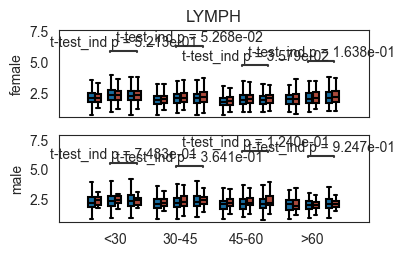

In [12]:
l_tags = [
    'v9057','v9064','v9045','v9058','v9059',
    'v9060','v9061','v9062','v9063','v9065',
    'v9051','v9055','v9089','v9091','v9090',
    'v9046','v9047','v9048','v9049','v9050',
]

l_age_groups = ['<30', '30-45', '45-60', '>60']
hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29"
]

# for tag in l_tags:
tag = "v9055"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", #order=l_age_groups,
                hue="group_each_year",y=tag,
                box_pairs=[
                        ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
                        (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
                        (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
                        (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
                ],
                test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    )

fig.savefig(f"{workdir}/Figure5_C.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure5_LYMPH-Twave.pdf")

## Boxplot with Pvalue: HBP

>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=8.336e-02 stat=-1.739e+00
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.055e-01 stat=-1.267e+00
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.543e-02 stat=-2.431e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=7.314e-01 stat=3.433e-01
>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=5.921e-01 stat=-5.375e-01
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.760e-01 stat=-1.092e+00
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.744e-01 stat=-1.363e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=2.750e-04 stat=-3.657e+00


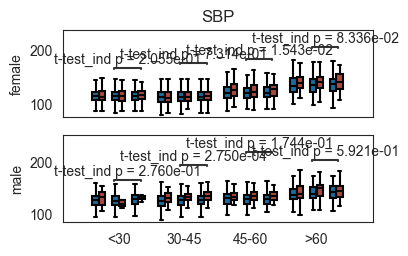

In [13]:
tag = "v000762"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", #order=l_age_groups,
                hue="group_each_year",y=tag,
                box_pairs=[
                        ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
                        (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
                        (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
                        (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
                ],
                test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    )
    
# fig.savefig(f"{workdir}/Figure3_C-1.pdf")

## Barplot with Chi Square Exam, LIVER.Steatosis

In [14]:
def extract_chi2_table(df_t_group, gender, tag, l_age_group_subs=None, compares=None):
    if l_age_group_subs is None:
        l_age_group_subs = ["<30", "30-45"]

    if compares is None:
        compares = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

    np_table = np.zeros([2,2])
    for age in l_age_group_subs:
        arr1 = df_t_group[[tag, "group_num", "age_groups"]][
                        (df_t_group["gender"]==gender) &
                        (df_t_group["age_groups"]==age) &
                        (df_t_group["group_each_year"]==compares[0])
        ][tag].dropna().values
        arr2 = df_t_group[[tag, "group_num", "age_groups"]][
                        (df_t_group["gender"]==gender) &
                        (df_t_group["age_groups"]==age) &
                        (df_t_group["group_each_year"]==compares[1])
        ][tag].dropna().values
        
        np_table += np.array([
            [arr1.sum(), len(arr1)-arr1.sum()],
            [arr2.sum(), len(arr2)-arr2.sum()],
        ])
    
    return np_table


def print_chi2_table(df_t_group, gender, tag, l_age_group_subs=None, ax=None, compares=None):
    if l_age_group_subs is None:
        l_age_group_subs = ["<30", "30-45"]

    if compares is None:
        compares = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

    ax.axis('tight')
    ax.axis('off')
    np_table = extract_chi2_table(df_t_group, gender, tag, l_age_group_subs, compares)

    chi = scipy.stats.chi2_contingency(np_table)
    np_exp = chi.expected_freq
    list_table = [
        [f"{np_table[0,0]:.0f},({np_exp[0,0]:.2f})", f"{np_table[0,1]:.0f},({np_exp[0,1]:.0f})", f"{np_table[0,0]+np_table[0,1]:.0f}"],
        [f"{np_table[1,0]:.0f},({np_exp[1,0]:.2f})", f"{np_table[1,1]:.0f},({np_exp[1,1]:.0f})", f"{np_table[1,0]+np_table[1,1]:.0f}"],
        [f"{np_table[0,0]+np_table[1,0]:.0f}", f"{np_table[0,1]+np_table[1,1]:.0f}", f"{np_table[0,0]+np_table[1,0]+np_table[1,0]+np_table[1,1]:.0f}"],
    ]
    ax.set_title(f"{l_age_group_subs}, X2 = {chi.pvalue:.2e}")
    the_table = ax.table(cellText=list_table, 
                colLabels=[tag, f"No-{tag}", "rowSum"], 
                rowLabels=["T-wave-Normal", "T-wave-Abnormal", "colSum"],
                edges="open",             
                loc="center"
            )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(7)

<Figure size 800x500 with 0 Axes>

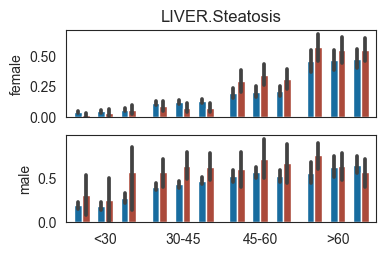

In [15]:
fig = plt.figure(figsize=(8,5))
tag = "LIVER.Steatosis"

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]

idx = 0
gender = "female"

fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.barplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag,# showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        
fig.savefig(f"{workdir}/Figure6_B.pdf")

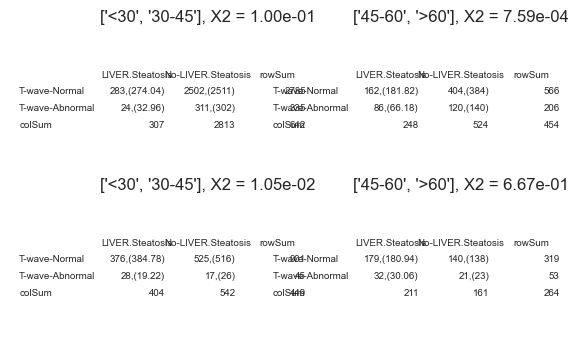

In [16]:
tag = "LIVER.Steatosis"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax)

fig.savefig(f"{workdir}/Figure6_C.pdf")

# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure6_steaosis-chisq2.pdf")

## Barplot with Chi Square Exam, LUNG.GroundGlassOpacity in 2022

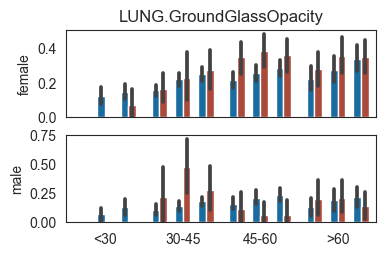

In [17]:

tag = "LUNG.GroundGlassOpacity"

l_age_groups = ['<30', '30-45', '45-60', '>60']
hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29"
]

fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.barplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag,# showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
        
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure6_steaosis.pdf")
df_t_group[(df_t_group["gender"]==gender)][[tag, "group_num", "age_groups"]].dropna().pivot_table(
    index="group_num", columns="age_groups", aggfunc=len, values=tag
)

fig.savefig(f"{workdir}/Figure4_B.pdf")


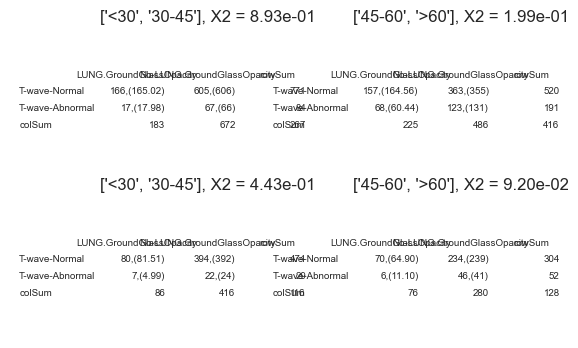

In [18]:

cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]
tag = "LUNG.GroundGlassOpacity"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/FigureS4_A.pdf")


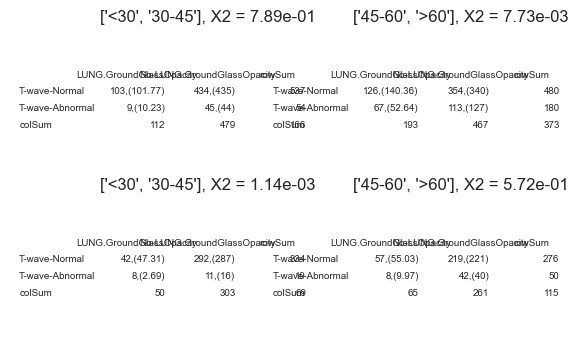

In [19]:
cmp = ["t-norm_2023-Control-2022", "t-abnorm_2023-Control-2022"]
tag = "LUNG.GroundGlassOpacity"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/FigureS4_B.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure6_steaosis-chisq2.pdf")

## Barplot with Chi Square Exam, is SBP > 139.5

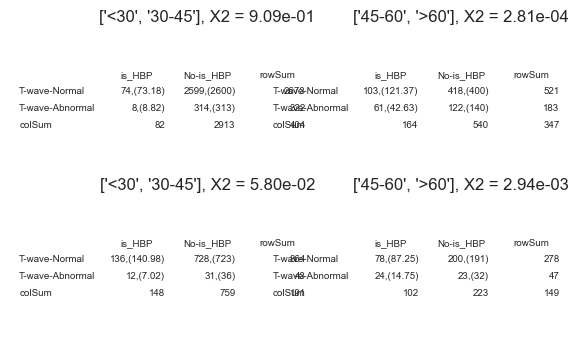

In [20]:
cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

df_t_group["is_HBP"] = [1 if x > 139.5 else 0 for x in df_t_group["v000762"]]
df_t_group["is_HBP"][ pd.isna(df_t_group["v000762"]) ] = pd.NA
tag = "is_HBP"


gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/Figure3_SBP.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure3_HBP.pdf")

## Barplot with Chi Square Exam, is FBG > 5.6

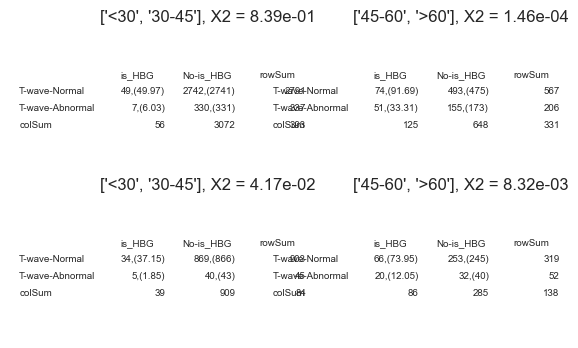

In [21]:
cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

df_t_group["is_HBG"] = [1 if x > 5.6 else 0 for x in df_t_group["v0023"]]
df_t_group["is_HBG"][ pd.isna(df_t_group["v0023"]) ] = pd.NA
tag = "is_HBG"


gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)
fig.savefig(f"{workdir}/Figure3_HBG.pdf")
# fig.savefig("../../analysis/liuzhong/human/clinical/figures/Figure3_HBG.pdf")

## Other boxplots

gender                      female                         male                \
age_groups                     <30   30-45  45-60    >60    <30  30-45  45-60   
group_each_year                                                                 
t-abnorm_2023-Control-2021   169.0   190.0  101.0   83.0   13.0   34.0   19.0   
t-abnorm_2023-Control-2022   141.0   205.0  108.0   88.0    8.0   39.0   17.0   
t-abnorm_2023-Test-2023      128.0   209.0  111.0   95.0    7.0   38.0   17.0   
t-norm_2023-Control-2021    1395.0  1487.0  337.0  136.0  349.0  599.0  198.0   
t-norm_2023-Control-2022    1241.0  1611.0  362.0  147.0  288.0  631.0  218.0   
t-norm_2023-Test-2023       1117.0  1673.0  404.0  162.0  235.0  658.0  234.0   
t-abnorm_2023-Control-2021   169.0   190.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   142.0   205.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      128.0   209.0  111.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1395.0  1488.0  337.0  136.0  352.0  604.0  201.0   
t-norm_2023-Control-2022    1241.0  1612.0  362.0  147.0  292.0  636.0  221.0   
t-norm_2023-Test-2023       1117.0  1674.0  405.0  162.0  240.0  663.0  236.0   
t-abnorm_2023-Control-2021   168.0   182.0   93.0   81.0   12.0   31.0   19.0   
t-abnorm_2023-Control-2022   138.0   192.0   97.0   84.0    8.0   34.0   16.0   
t-abnorm_2023-Test-2023      126.0   196.0   95.0   88.0    7.0   36.0   17.0   
t-norm_2023-Control-2021    1384.0  1415.0  307.0  133.0  347.0  569.0  171.0   
t-norm_2023-Control-2022    1225.0  1519.0  332.0  140.0  288.0  605.0  193.0   
t-norm_2023-Test-2023       1103.0  1570.0  373.0  148.0  235.0  629.0  199.0   
t-abnorm_2023-Control-2021   119.0   179.0   98.0   79.0    9.0   32.0   19.0   
t-abnorm_2023-Control-2022     NaN    25.0   33.0   21.0    1.0   11.0    8.0   
t-abnorm_2023-Test-2023        1.0    22.0   36.0   29.0    2.0    9.0    9.0   
t-norm_2023-Control-2021     885.0  1394.0  323.0  126.0  211.0  536.0  187.0   
t-norm_2023-Control-2022      20.0   145.0  112.0   38.0   12.0  124.0  137.0   
t-norm_2023-Test-2023         12.0   159.0  125.0   43.0    8.0  127.0  149.0   
t-abnorm_2023-Control-2021   169.0   190.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   142.0   205.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      128.0   209.0  111.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1395.0  1488.0  337.0  136.0  352.0  604.0  201.0   
t-norm_2023-Control-2022    1241.0  1612.0  362.0  147.0  292.0  636.0  221.0   
t-norm_2023-Test-2023       1117.0  1674.0  405.0  162.0  240.0  663.0  236.0   
t-abnorm_2023-Control-2021   169.0   190.0  101.0   83.0   13.0   35.0   19.0   
t-abnorm_2023-Control-2022   142.0   205.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      128.0   209.0  110.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1395.0  1489.0  337.0  136.0  352.0  604.0  203.0   
t-norm_2023-Control-2022    1241.0  1612.0  362.0  146.0  292.0  637.0  222.0   
t-norm_2023-Test-2023       1115.0  1674.0  405.0  162.0  240.0  664.0  237.0   
t-abnorm_2023-Control-2021   169.0   190.0  101.0   83.0   13.0   35.0   19.0   
t-abnorm_2023-Control-2022   142.0   205.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      128.0   209.0  110.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1395.0  1489.0  337.0  136.0  352.0  604.0  203.0   
t-norm_2023-Control-2022    1241.0  1612.0  362.0  146.0  292.0  637.0  222.0   
t-norm_2023-Test-2023       1115.0  1674.0  405.0  162.0  240.0  664.0  237.0   
t-abnorm_2023-Control-2021   169.0   190.0  101.0   83.0   13.0   35.0   19.0   
t-abnorm_2023-Control-2022   142.0   205.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      128.0   209.0  110.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1395.0  1489.0  337.0  136.0  352.0  604.0  203.0   
t-norm_2023-Control-2022    124

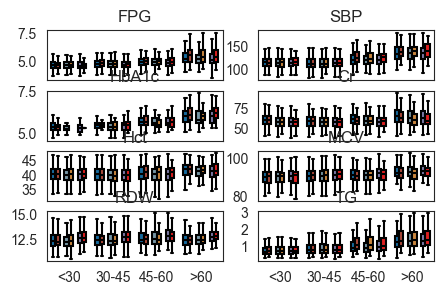

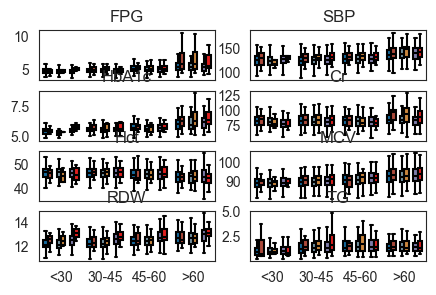

In [22]:
# from utils import parse_dict_with_default
l_orders = [
    "v0023", 'v000762', "v1164", "v0032", 
    "v9059", "v9060", "v9063", "v0009",
]

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [ "#0172B6", "#BD3C29", "#000000",
        "#6F99AD", "#E18727", "#000000",
        "#7876B1", "#FF0000"]

new_cols =  pd.MultiIndex.from_tuples([
            (  'female',   '<30'),        
            (  'female', '30-45'),
            (  'female', '45-60'),
            (  'female',   '>60'),
            (    'male',   '<30'),
            (    'male', '30-45'),
            (    'male', '45-60'),
            (    'male',   '>60'),
            (     'tag',      ''),
            ('tag_name',      '')
])


n_col = 2
l_df_box_n = []
for gender in ["female", "male"]:
    fig = plt.figure(figsize=(5,3))
    for idx,tag in enumerate(l_orders):
        if gender == "male":
            l_df_box_n.append(df_n_boxes)

        ax = fig.add_subplot(4,n_col,1+idx)
        sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", hue="group_each_year", y=tag, showfliers = False,
                    hue_order=hue_order, palette=pal, ax=ax)
            
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
        if idx < len(l_orders) - n_col:
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        l_col_used = ["gender", "age_groups", "group_each_year"]
        df_n_boxes = df_t_group[l_col_used + [tag]].dropna()[l_col_used].pivot_table(
                        index="group_each_year", columns=["gender", "age_groups"], aggfunc=len
        )
        df_n_boxes["tag"] = tag
        df_n_boxes["tag_name"] = parse_dict_with_default(tag, rename_dict)
    
    fig.savefig(f"{workdir}/Figure3_C-{gender}.pdf")
    # fig.savefig(f"../../analysis/liuzhong/human/clinical/figures/Figure3_why_Tchange-{gender}.pdf")

df_res = pd.concat(l_df_box_n)
df_res[new_cols]

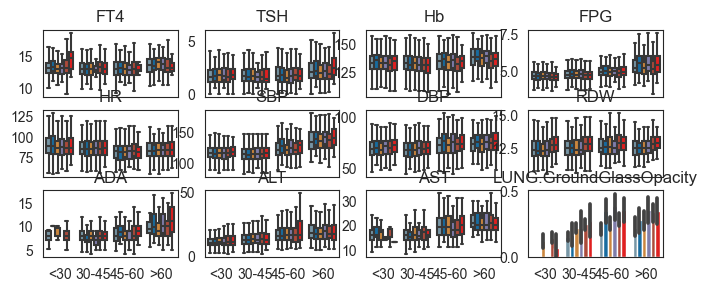

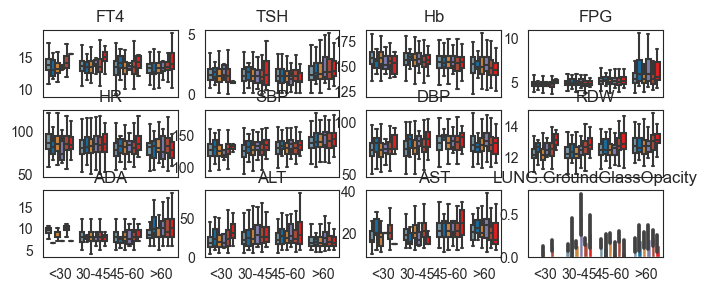

In [23]:
from utils import parse_dict_with_default
l_orders = [
    'v9462', 'v9461', "v9058", "v0023",
    'v000763','v000762', 'v002161', 'v9063',
    "v1162",'v0017', 'v0045', "LUNG.GroundGlassOpacity",
]

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [ "#6F99AD", "#0172B6", "#E18727",  "#7876B1",  "#BD3C29", "#FF0000"]
for gender in ["female", "male"]:
    fig = plt.figure(figsize=(8,4))
    for idx,tag in enumerate(l_orders):
        ax = fig.add_subplot(4,4,1+idx)
        if idx != len(l_orders) -1:
            sns.boxplot(df_t_group[(df_t_group["gender"]==gender)],
                            x="age_groups", hue="group_each_year", y=tag, showfliers = False,
                            hue_order=hue_order, palette=pal, ax=ax)
        else:
            sns.barplot(df_t_group[(df_t_group["gender"]==gender)],
                            x="age_groups", hue="group_each_year", y=tag,
                            hue_order=hue_order, palette=pal, ax=ax)
            
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
        if idx < len(l_orders) - 4:
            ax.set_xticks([])
            ax.set_xticklabels([])
        
    # fig.savefig(f"../../analysis/liuzhong/human/clinical/figures/Figure3_why_Tchange-{gender}.pdf")
# fig = plt.figure(figsize=(25,25))
# for idx,tag in enumerate(l_orders):
#     ax = fig.add_subplot(4,4,1+idx)
#     sns.violinplot(df_t_group[df_t_group["gender"]=="male"], x="age_groups", hue="group", y=tag, 
#                 hue_order=["t-norm_2023","t-abnorm_22-23","t-abnorm_2023"], 
#                 palette=["#0172B6", "#E18727", "#BD3C29"], ax=ax
#)
#     ax.set_title(parse_dict_with_default(tag, rename_dict))

>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=3.706e-01 stat=9.024e-01
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=nan stat=nan
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=7.837e-02 stat=1.772e+00
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=7.349e-03 stat=2.712e+00
>60_t-norm_2023-Test-2023 v.s. >60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=1.970e-01 stat=1.305e+00
<30_t-norm_2023-Test-2023 v.s. <30_t-abnorm_2023-Test-2023: t-test independent samples, P_val=nan stat=nan
45-60_t-norm_2023-Test-2023 v.s. 45-60_t-abnorm_2023-Test-2023: t-test independent samples, P_val=5.993e-01 stat=5.265e-01
30-45_t-norm_2023-Test-2023 v.s. 30-45_t-abnorm_2023-Test-2023: t-test independent samples, P_val=9.502e-01 stat=-6.255e-02


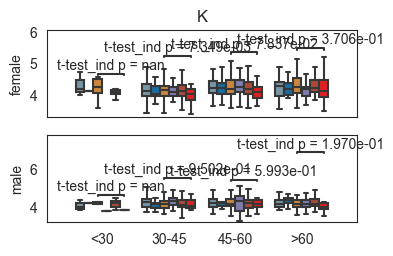

In [24]:
tag = "v0002"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", #order=l_age_groups,
                hue="group_each_year",y=tag,
                box_pairs=[
                        ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
                        (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
                        (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
                        (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
                ],
                test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    )

# Other plots

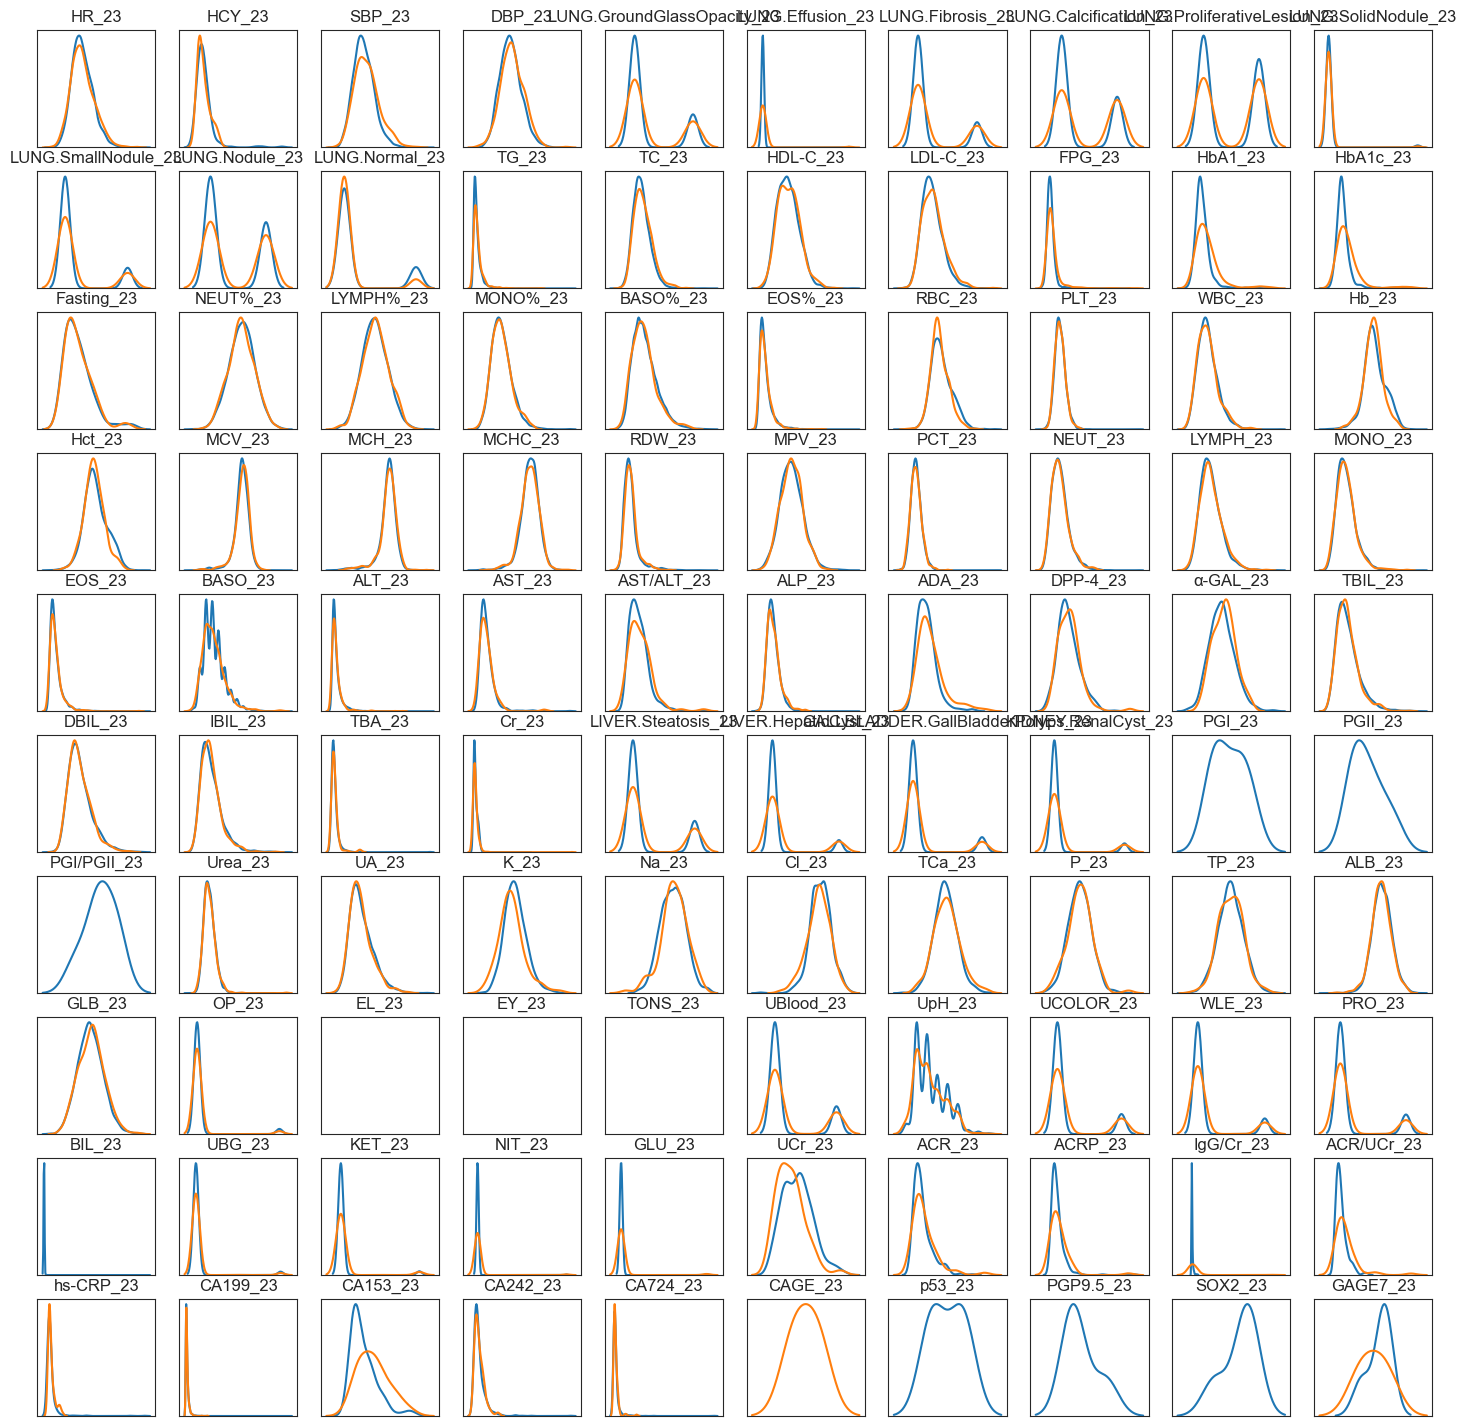

In [25]:
l_import_tags = [
    "HbA1_23", "ADA_23", "SBP_23", "FPG_23",
    "LUNG.GroundGlassOpacity_23", "ALT_23", "TSH_23","T3_23",
]

l_import_tags = list(df_X.columns[0:100])
fig = plt.figure(figsize=(18,18))
for idx,tag_import in enumerate(l_import_tags):
    ax = fig.add_subplot(10,10,idx+1)
    df_ = df_X[[tag_import]]
    df_["Y"] = df_Y.values
    try:
        sns.kdeplot(data=df_[df_["Y"]==0], x=tag_import, ax=ax)
        sns.kdeplot(data=df_[df_["Y"]==1], x=tag_import, ax=ax)
    except:
        pass

    ax.set_title(tag_import)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_yticklabels([])

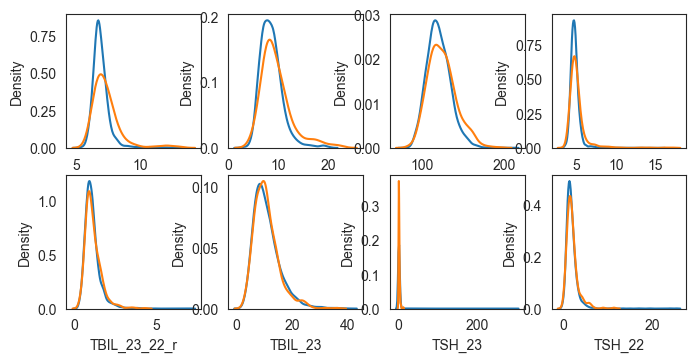

In [26]:
tag = "RDW_23_22_r"
tag = "HbA1_23"
tag = "ADA_23"
tag = "SBP_23"

l_import_tags = [
    "HbA1_23", "ADA_23", "SBP_23", "FPG_23",
    "TBIL_23_22_r", "TBIL_23", "TSH_23","TSH_22",

]
fig = plt.figure(figsize=(8,8))
for idx,tag_import in enumerate(l_import_tags):
    ax = fig.add_subplot(4,4,idx+1)
    df_ = df_X[[tag_import]]
    df_["Y"] = df_Y.values
    sns.kdeplot(data=df_[df_["Y"]==0], x=tag_import, ax=ax)
    sns.kdeplot(data=df_[df_["Y"]==1], x=tag_import, ax=ax)

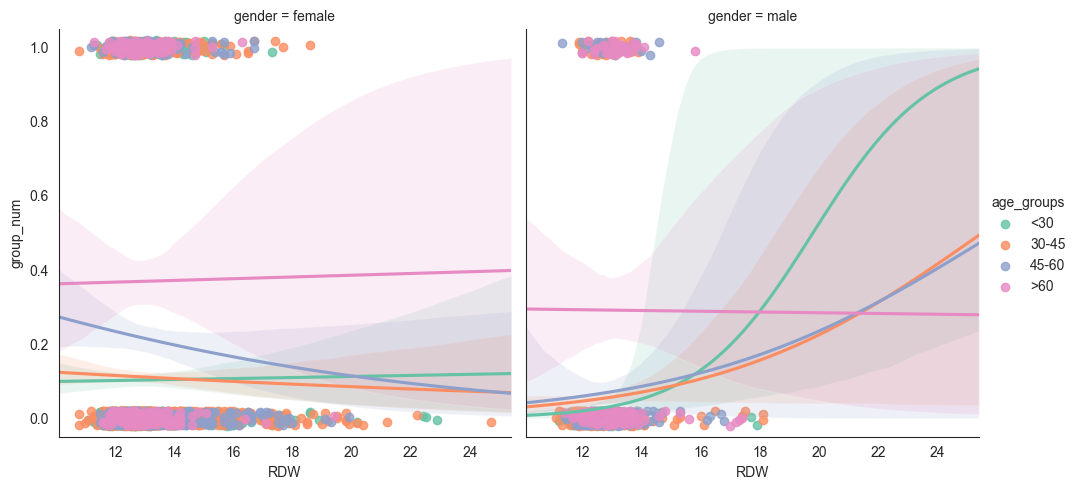

In [27]:
tag = "v9063"
g = sns.lmplot(data=df_t_group[df_t_group["period"]=="Test-2023"],
                   x=tag, y="group_num", col="gender", hue="age_groups", 
                   palette="Set2", y_jitter=.02, logistic=True, truncate=False, 
                   hue_order=["<30","30-45","45-60",">60"])
g.set(ylim=(-.05, 1.05), xlabel="%s" % (parse_dict_with_default(tag, default_dict=rename_dict)))